In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [89]:
# Load and clean data
df_skaters = pd.read_csv("skaters_1996_2023.csv")
df_skaters = df_skaters[df_skaters['RK'] != 'Rk']

df_skaters.sort_values(['PLAYER', 'POS', 'SEASON'], inplace=True)
df_skaters['PS'] = df_skaters['PS'].astype('float64')

# Define the weights for the past three seasons
weights = {1: 0.5, 2: 0.3, 3: 0.2}

# Define the age adjustment factors (hypothetical)
age_adjustment = {i: 1 - (i - 28) * 0.01 for i in range(18, 50)}

def calculate_weighted_ps(player_data: pd.DataFrame):
    # Calculate weighted point shares based on past three seasons
    weighted_ps = sum(weights[i] * player_data['PS'].shift(i).fillna(player_data['PS']) for i in weights)
    return weighted_ps.set_axis(player_data['SEASON'])

def apply_age_adjustment(player_data: pd.DataFrame):
    # Apply age adjustment factor
    player_data['FORECAST_PS'] *= player_data['AGE'].astype(int).apply(lambda x: age_adjustment.get(x, 1))
    return player_data['FORECAST_PS'].values

def apply_regression(player_data: pd.DataFrame):
    # Apply regression towards the mean
    league_min_reg = min(1, (50 - (len(player_data) + 1)) / 100)
    player_projected_league_average = projected_league_average_ps_per_position[zip(player_data['POS'], player_data['SEASON'])]
    # player_projected_league_average = projected_league_average_ps_per_position[player_data['SEASON']]
    return (1 - league_min_reg) * player_data['FORECAST_PS'].values + (league_min_reg) * player_projected_league_average.values


league_average_ps = df_skaters.groupby(['POS','SEASON'])['PS'].mean().reset_index()
projected_league_average_ps_per_position = league_average_ps.groupby('POS').apply(calculate_weighted_ps)
# league_average_ps = df_skaters.groupby(['SEASON'])['PS'].mean().reset_index()
# projected_league_average_ps_per_position = league_average_ps.groupby('SEASON').apply(calculate_weighted_ps)


In [90]:
df_skaters['FORECAST_PS'] = np.nan
min_ps = df_skaters['PS'].min()
df_skaters['PS'] += abs(min_ps)  # prevent negatives for scaling, reverted in the end


# Group by player and apply the forecasting system
weighted_ps = df_skaters.groupby('PLAYER').apply(calculate_weighted_ps)
df_skaters['FORECAST_PS'] = weighted_ps.values

# Find the index of the first season for each combination of PLAYER and POS
first_season_indices = df_skaters.groupby(['PLAYER', 'POS'])['SEASON'].idxmin()

# Drop these rows from the DataFrame, since can't predict first season
df_skaters = df_skaters.drop(first_season_indices)


age_adjusted_weighted_ps = df_skaters.groupby('PLAYER').apply(apply_age_adjustment)
df_skaters['FORECAST_PS'] = [year_proj for players in age_adjusted_weighted_ps for year_proj in players]

mean_reg_weighted_ps = df_skaters.groupby('PLAYER').apply(apply_regression)
df_skaters['FORECAST_PS'] = [year_proj for players in mean_reg_weighted_ps for year_proj in players]


df_skaters['PS'] -= abs(min_ps)
df_skaters['FORECAST_PS'] -= abs(min_ps)

df_skaters['DELTA_PS'] = (df_skaters['PS'] - df_skaters['FORECAST_PS'])

df_skaters[['PLAYER','POS','SEASON','PS','FORECAST_PS', 'DELTA_PS']]

,PLAYER,POS,SEASON,PS,FORECAST_PS,DELTA_PS
4977,A.J. Greer,LW,2018,0.2,0.012972,0.187028
4073,A.J. Greer,LW,2019,0.1,0.024745,0.075255
2274,A.J. Greer,LW,2021,0.0,0.029371,-0.029371
1287,A.J. Greer,LW,2022,0.2,-0.061931,0.261931
318,A.J. Greer,LW,2023,1.0,0.028650,0.971350
...,...,...,...,...,...,...
18804,Ľuboš Bartečko,LW,2001,1.0,1.646412,-0.646412
17924,Ľuboš Bartečko,LW,2002,2.1,1.186564,0.913436
17037,Ľuboš Bartečko,LW,2003,1.8,1.210237,0.589763
15015,Štefan Ružička,RW,2007,0.5,0.196937,0.303063


(array([  1.,   0.,  11., 153., 317., 150.,  68.,  28.,   8.,   4.]),
 array([-6.87563659, -5.22609557, -3.57655455, -1.92701353, -0.2774725 ,
         1.37206852,  3.02160954,  4.67115056,  6.32069158,  7.97023261,
         9.61977363]),
 <BarContainer object of 10 artists>)

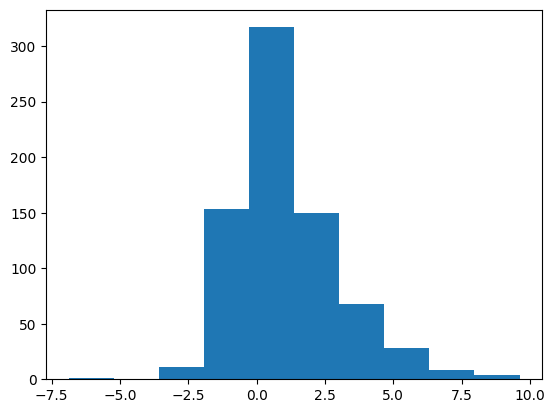

In [91]:
plt.hist(df_skaters['DELTA_PS'])
plt.hist(df_skaters_small_reg['DELTA_PS'])

In [88]:
df_skaters_small_reg = df_skaters


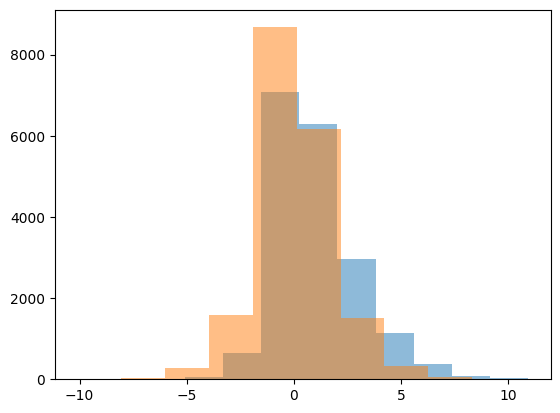

In [94]:
plt.hist(df_skaters['DELTA_PS'], alpha=0.5)
plt.hist(df_skaters_small_reg['DELTA_PS'], alpha=0.5)

plt.show()